In [169]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [170]:
import warnings
warnings.filterwarnings('ignore', 'The behavior of `series.*`', FutureWarning)
warnings.filterwarnings('ignore', 'invalid value encountered', RuntimeWarning)


In [171]:
# model.save('1-v4-model.h5')
# model.save_weights('1-v4-weights.h5')
# # model.load_weights('v4-weights.h5')
# # model.load_model('v4-model.h5')
# # Evaluate the model
# train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)
# print("Train Loss:", train_loss)
# print("Test Loss:", test_loss)

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import yfinance as yf
from datetime import datetime

In [173]:
import ta 

In [174]:

# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\test\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
bitcoin_data.dropna(inplace=True)
bitcoin_data = bitcoin_data.tail(10000)
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4847340,1616546640,53932.65,53964.98,53890.49,53933.94,4.461309,240505.976100,53909.279177
4847341,1616546700,53941.21,53941.21,53881.91,53924.01,0.895911,48285.816233,53895.745115
4847342,1616546760,53913.64,54000.07,53906.62,54000.07,0.813743,43909.304002,53959.692861
4847343,1616546820,54026.47,54029.61,53947.83,53986.99,1.425590,76996.998595,54010.619178
4847344,1616546880,53986.98,54021.16,53958.20,54000.64,0.814179,43961.386467,53994.712574
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [176]:
# bitcoin_data = add_all_ta_features(bitcoin_data,
#                                            open="Open",
#                                            high="High",
#                                            low="Low",
#                                            close="Close",
#                                            volume="Volume_(Currency)",
#                                            fillna=True)
# add RSI, MACD, MACD signal, MACD histogram
# bitcoin_data['RSI'] = ta.momentum.rsi(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD'] = ta.trend.macd(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_signal'] = ta.trend.macd_signal(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['SMA_20'] = ta.trend.sma_indicator(close=bitcoin_data["Close"], fillna=True)

In [214]:
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[["Close"]])
# add more features to scaled data
# scaled_data = scaler.fit_transform(bitcoin_data[["Close", "Volume_(BTC)", "Volume_(Currency)", "RSI", "MACD", "MACD_signal", "MACD_diff", "SMA_20"]])


In [215]:
# Create sequences of data with a given time step
time_step = 60  # Number of previous time steps to consider for predicting the next time step
X = []
y = []
for i in range(time_step, len(scaled_data) - 30):
    X.append(scaled_data[i - time_step:i, 0])
    y.append(scaled_data[i:i + 30, 0])
X = np.array(X)
y = np.array(y)

In [216]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [217]:
# Reshape X to match the expected input shape of the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [218]:

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=30))

In [219]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [220]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


248/248 [==============================] - 9s 28ms/step - loss: 0.0307 - val_loss: 0.0026
Epoch 2/50
248/248 [==============================] - 6s 25ms/step - loss: 0.0068 - val_loss: 0.0015
Epoch 3/50
248/248 [==============================] - 6s 24ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 4/50
248/248 [==============================] - 6s 24ms/step - loss: 0.0037 - val_loss: 8.1436e-04
Epoch 5/50
248/248 [==============================] - 6s 23ms/step - loss: 0.0032 - val_loss: 7.9565e-04
Epoch 6/50
248/248 [==============================] - 6s 23ms/step - loss: 0.0028 - val_loss: 9.5879e-04
Epoch 7/50
248/248 [==============================] - 6s 23ms/step - loss: 0.0025 - val_loss: 9.4495e-04
Epoch 8/50
248/248 [==============================] - 6s 23ms/step - loss: 0.0023 - val_loss: 9.1542e-04
Epoch 9/50
248/248 [==============================] - 6s 22ms/step - loss: 0.0021 - val_loss: 8.3273e-04
Epoch 10/50
248/248 [==============================] - 5s 22ms/step - loss: 0.

In [221]:
now = datetime.now()
format_date = now.strftime("%Y-%m-%d-%H-%M")
model.save(f'models/1-v4-model_{format_date}.h5')
model.save_weights(f'models/1-v4-weights_{format_date}.h5')
# model.load_weights('v4-weights.h5')
# model.load_model('v4-model.h5')

In [222]:
# Make predictions
predictions = model.predict(X_test)


62/62 [==============================] - 1s 7ms/step


In [229]:
# Scale the predictions back to original values
predictions = scaler.inverse_transform(predictions)
# Scale the predictions back to original values
# Reshape the predictions to match the expected shape of (1982, 30)

ValueError: operands could not be broadcast together with shapes (1982,30) (8,) (1982,30) 

In [ ]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 55385.563149025395


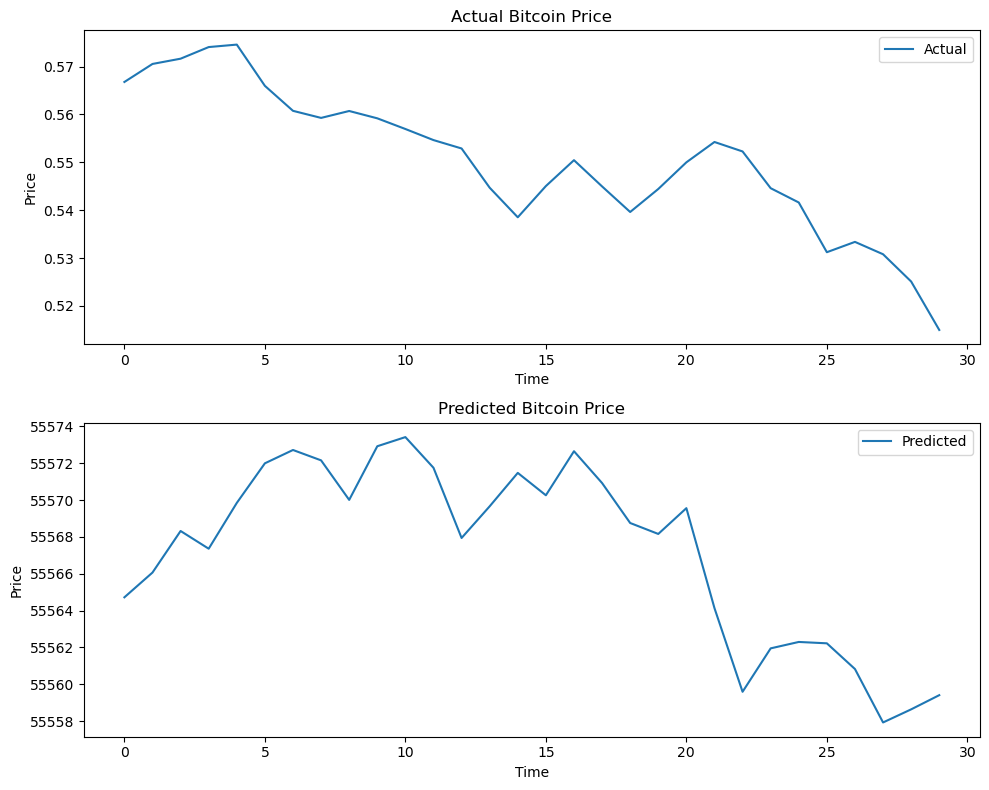

In [ ]:
# Create two separate subplots for actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual values
ax1.plot(y_test[0], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted values
ax2.plot(predictions[0], label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Format the tick labels to display numbers in regular format
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
bitcoin_data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,RSI,MACD,MACD_signal,MACD_diff,SMA_20
4857366,1617148200,58673.20,58689.44,58673.20,58689.44,0.576412,33822.378068,58677.435702,54.570922,-3.433749,-9.832748,6.398999,58638.223333
4857367,1617148260,58677.05,58699.90,58660.00,58699.90,2.672676,156832.692130,58680.021260,55.966609,0.372423,-7.791714,8.164137,58645.177500
4857369,1617148380,58718.68,58731.23,58698.34,58698.50,0.207983,12209.055282,58702.294657,55.719866,3.238542,-5.585663,8.824205,58652.025000
4857370,1617148440,58736.19,58762.43,58736.19,58739.95,0.041559,2441.376572,58745.145351,61.177238,8.753722,-2.717786,11.471508,58662.326667
4857371,1617148500,58742.18,58742.18,58714.31,58714.31,2.519999,148004.448110,58731.946927,56.535565,10.929619,0.011695,10.917924,58670.136667
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,51.857139,10.251480,2.059652,8.191828,58676.605000
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,51.826141,9.588192,3.565360,6.022832,58683.755833
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,57.324721,11.992987,5.250885,6.742101,58694.075833
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,61.855629,16.672037,7.535116,9.136921,58701.913333
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,63.834842,21.551156,10.338324,11.212832,58708.195833


In [ ]:
# timestamp to datetime
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], unit='s')
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,RSI,MACD,MACD_signal,MACD_diff,SMA_20
4847340,2021-03-24 00:44:00,53932.65,53964.98,53890.49,53933.94,4.461309,240505.976100,53909.279177,100.000000,0.000000,0.000000,0.000000,53933.940000
4847341,2021-03-24 00:45:00,53941.21,53941.21,53881.91,53924.01,0.895911,48285.816233,53895.745115,0.000000,-0.792137,-0.158427,-0.633709,53928.975000
4847342,2021-03-24 00:46:00,53913.64,54000.07,53906.62,54000.07,0.813743,43909.304002,53959.692861,89.187808,4.663735,0.806005,3.857730,53952.673333
4847343,2021-03-24 00:47:00,54026.47,54029.61,53947.83,53986.99,1.425590,76996.998595,54010.619178,76.544628,7.841711,2.213146,5.628565,53961.252500
4847344,2021-03-24 00:48:00,53986.98,54021.16,53958.20,54000.64,0.814179,43961.386467,53994.712574,79.767929,11.331104,4.036738,7.294366,53969.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,51.857139,10.251480,2.059652,8.191828,58676.605000
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,51.826141,9.588192,3.565360,6.022832,58683.755833
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,57.324721,11.992987,5.250885,6.742101,58694.075833
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,61.855629,16.672037,7.535116,9.136921,58701.913333


In [ ]:
import yfinance as yf
from datetime import datetime

In [ ]:
# downloade the data with yfinance, get the last 2 hours
last_60_minutes = yf.download(tickers='BTC-USD', period='2h', interval='1m')

[*********************100%***********************]  1 of 1 completed


In [ ]:

# 2. Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[["Close"]])
# 3. Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], 1)) # cannot reshape array of size 60 into shape (1,1,1)
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)
pred

1/1 [==============================] - 0s 13ms/step


array([[25310.268, 25310.357, 25310.408, 25310.617, 25310.65 , 25310.635,
        25310.814, 25310.793, 25310.73 , 25310.906, 25310.938, 25310.7  ,
        25310.602, 25310.71 , 25310.764, 25310.672, 25310.701, 25310.68 ,
        25310.67 , 25310.705, 25310.682, 25310.605, 25310.469, 25310.463,
        25310.576, 25310.586, 25310.512, 25310.508, 25310.496, 25310.53 ]],
      dtype=float32)

In [ ]:
# 5. Print the predicted price
print("The Bitcoin price will move from {} to {} in the next 30 minutes.".format(last_60_minutes["Close"].iloc[-1], pred[0][-1]))


The Bitcoin price will move from 25309.744140625 to 25310.529296875 in the next 30 minutes.


In [ ]:
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)



1/1 [==============================] - 0s 17ms/step


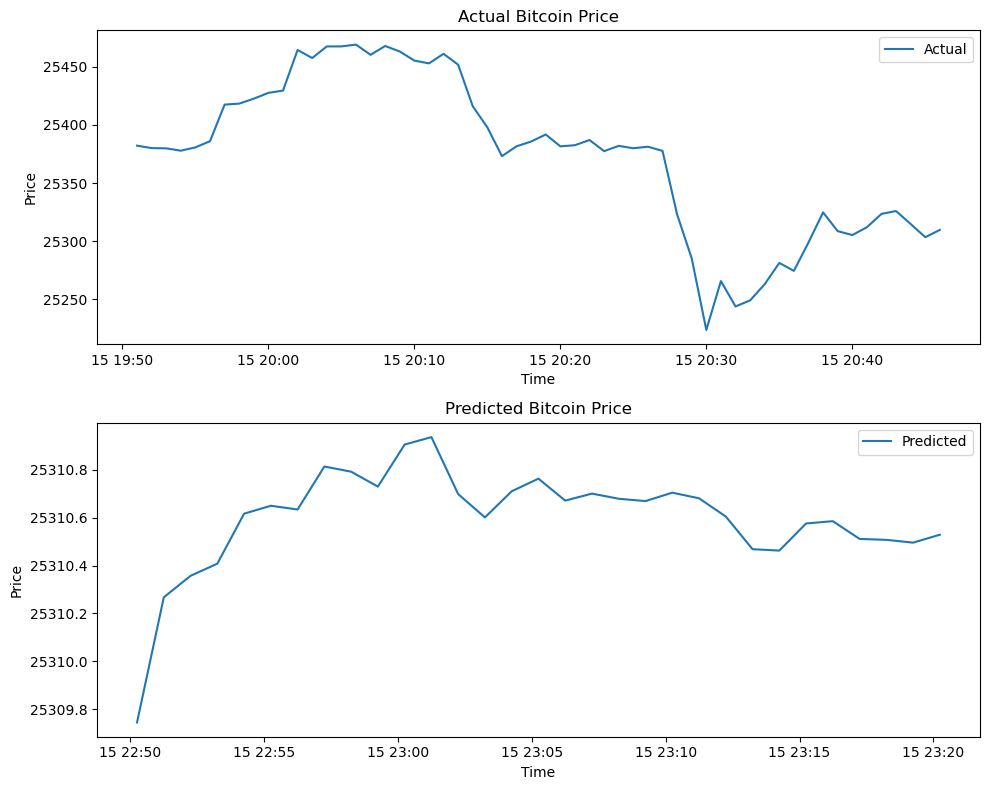

In [ ]:
# Create two separate subplots for actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual values
ax1.plot(last_60_minutes.index, last_60_minutes["Close"], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted values
pred_time = pd.date_range(start=now, periods=31, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0][:30]))
ax2.plot(pred_time, pred_values, label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()



# Format the tick labels to display numbers in regular format
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

# Display the plot
plt.tight_layout()
plt.show()

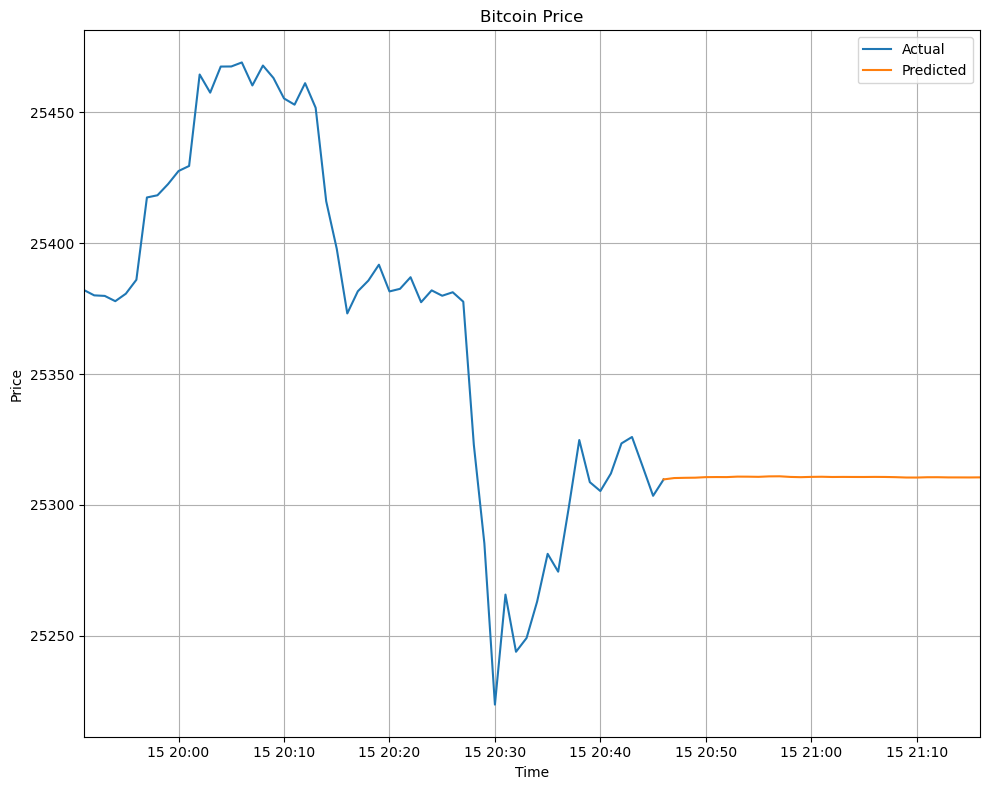

In [ ]:
# Create a single subplot for both actual and predicted values
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the actual values
ax.plot(last_60_minutes.index, last_60_minutes["Close"], label='Actual')
ax.grid(True)
ax.set_title('Bitcoin Price')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Plot the predicted values
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=31, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0][:30]))
ax.plot(pred_time, pred_values, label='Predicted')

# Format the tick labels to display numbers in regular format
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Set the x-axis limits to show both actual and predicted values
ax.set_xlim(last_60_minutes.index[0], pred_time[-1])

# Display the legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
